In [1]:
import spynnaker.pyNN as p
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from brian2.units import *
import spynnaker_extra_pynn_models as q

c:\python27\lib\site-packages\Cython\Distutils\old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


In [2]:
p.setup(timestep=1.0, min_delay=1.0, max_delay=144.0)
n_neurons = 100

In [3]:
run_time = 1000 * ms
f_p1 = 50 * Hz
f_p2 = 10 * Hz
p_connection = .1
s_max = 32

In [4]:
cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.0,
                   'tau_m': 20.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 5.0,
                   'tau_syn_I': 5.0,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }

In [5]:
weight_to_spike = 1.
delay = 1

In [6]:
p1 = p.Population(n_neurons, p.IF_curr_exp, cell_params_lif,
                   label='pop_1')
p2 = p.Population(n_neurons, p.IF_curr_exp, cell_params_lif,
                   label='pop_2')
inhibitor_population = p.Population(n_neurons/2, p.IF_curr_exp, cell_params_lif,
                   label='inhibitor_pop')

In [7]:
stdp_model = p.STDPMechanism(
    timing_dependence=p.SpikePairRule(tau_plus=20., tau_minus=20.0,nearest=True),
    weight_dependence=p.AdditiveWeightDependence(w_min=0.0, w_max=1.0,A_plus=0.02, A_minus=0.02)
)
stdp_model = p.STDPMechanism(
    timing_dependence = q.Vogels2011Rule(alpha=0.12,tau=20.0),
    weight_dependence = p.AdditiveWeightDependence(w_min=0.0, w_max=1.0, A_plus=0.05),
    mad=True
)

In [8]:
p.Projection(inhibitor_population, p2, p.FixedProbabilityConnector(p_connection, weight_to_spike), target='inhibitory', 
             label='inhib ->2', synapse_dynamics=p.SynapseDynamics(slow=stdp_model))
p.Projection(inhibitor_population, p1, p.FixedProbabilityConnector(p_connection, weight_to_spike), target='inhibitory', 
             label='inhib ->1', synapse_dynamics=p.SynapseDynamics(slow=stdp_model))
p.Projection(p1, inhibitor_population, p.FixedProbabilityConnector(p_connection, weight_to_spike), target='excitatory', 
             label='inhib ->1')#, synapse_dynamics=p.SynapseDynamics(slow=stdp_model))
p.Projection(p2, inhibitor_population, p.FixedProbabilityConnector(p_connection, weight_to_spike), target='excitatory', 
             label='inhib ->1')#, synapse_dynamics=p.SynapseDynamics(slow=stdp_model))

projection inhib ->1

In [9]:
p.Projection(p1, p1, p.FixedProbabilityConnector(p_connection,weight_to_spike), label='excite 1->1')
p.Projection(p2, p2, p.FixedProbabilityConnector(p_connection,weight_to_spike), label='excite 2->2')
p.Projection(inhibitor_population, inhibitor_population, p.OneToOneConnector(weight_to_spike/2.),  target='inhibitory', 
             label='inhibit inhib->inhib')

projection inhibit inhib->inhib

In [10]:
p1.record_v()
p1.record_gsyn()
p1.record()
p2.record_v()
p2.record_gsyn()
p2.record()

In [11]:
# Input rates
p1_spike_times= np.linspace(0, run_time/ms, run_time * f_p1)
p2_spike_times= np.linspace(0, run_time/ms, run_time * f_p2)

t1 = p1_spike_times + run_time/ms
t2 = p2_spike_times + run_time/ms

d1 = t1 + run_time/ms 
d2 = t2 + run_time/ms

spikeArray_p1 = {'spike_times': np.concatenate((p1_spike_times,t2, d1))}
spikeArray_p2 = {'spike_times': np.concatenate((p2_spike_times,t1, d2))}

# Input populations
input_p1 = p.Population(1, p.SpikeSourceArray, spikeArray_p1,label='inputSpikes_p1')
input_p2 = p.Population(1, p.SpikeSourceArray, spikeArray_p2,label='inputSpikes_p2')

# Input connections
p.Projection(input_p1, p1, p.FixedProbabilityConnector(p_connection, weight_to_spike), label='excite input_p1->1')
p.Projection(input_p2, p2, p.FixedProbabilityConnector(p_connection, weight_to_spike), label='excite input_p2->2')

projection excite input_p2->2

In [12]:
p.run(3 * run_time/ms)

Allocating virtual identifiers
|0                           50%                         100%|
Partitioning graph vertices
|0                           50%                         100%|
Partitioning graph edges
|0                           50%                         100%|
Generating partitioner report
|0                           50%                         100%|
Filtering edges
|0                           50%                         100%|
Placing graph vertices
|0                           50%                         100%|
Generating placement report
|0                           50%                         100%|
Generating placement by core report
|0                           50%                         100%|
Generating SDRAM usage report
|0                           50%                         100%|
Routing
|0                           50%                         100%|
Allocating tags
|0                           50%                         100%|
Reporting Tags
|0                   

In [13]:
v_p1 = p1.get_v(compatible_output=True)
gsyn_p1 = p1.get_gsyn(compatible_output=True)
spikes_p1 = p1.getSpikes(compatible_output=True)
v_p2 = p2.get_v(compatible_output=True)
gsyn_p2 = p2.get_gsyn(compatible_output=True)
spikes_p2 = p2.getSpikes(compatible_output=True)
p.end()

Getting membrane voltage for pop_1
|0                           50%                         100%|
Getting conductance for pop_1
|0                           50%                         100%|
Getting spikes for pop_1
|0                           50%                         100%|
Getting membrane voltage for pop_2
|0                           50%                         100%|
Getting conductance for pop_2
|0                           50%                         100%|
Getting spikes for pop_2
|0                           50%                         100%|
Getting provenance data from machine graph
|0                           50%                         100%|
Getting provenance data
|0                           50%                         100%|
Getting Router Provenance
|0                           50%                         100%|
Extracting IOBUF
|0                           50%                         100%|


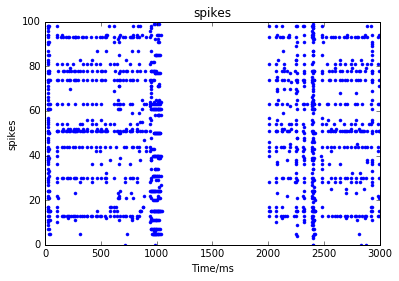

In [14]:
if spikes_p1 is not None:
#     print spikes_p1p2
    plt.figure()
    plt.plot([i[1] for i in spikes_p1], [i[0] for i in spikes_p1], ".")
    plt.xlabel('Time/ms')
    plt.ylabel('spikes')
    plt.title('spikes')

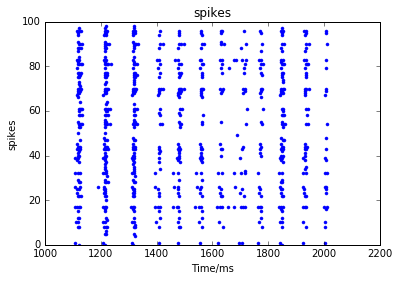

In [15]:
if spikes_p2 is not None:
#     print spikes_p1
    plt.figure()
    plt.plot([i[1] for i in spikes_p2], [i[0] for i in spikes_p2], ".")
    plt.xlabel('Time/ms')
    plt.ylabel('spikes')
    plt.title('spikes')

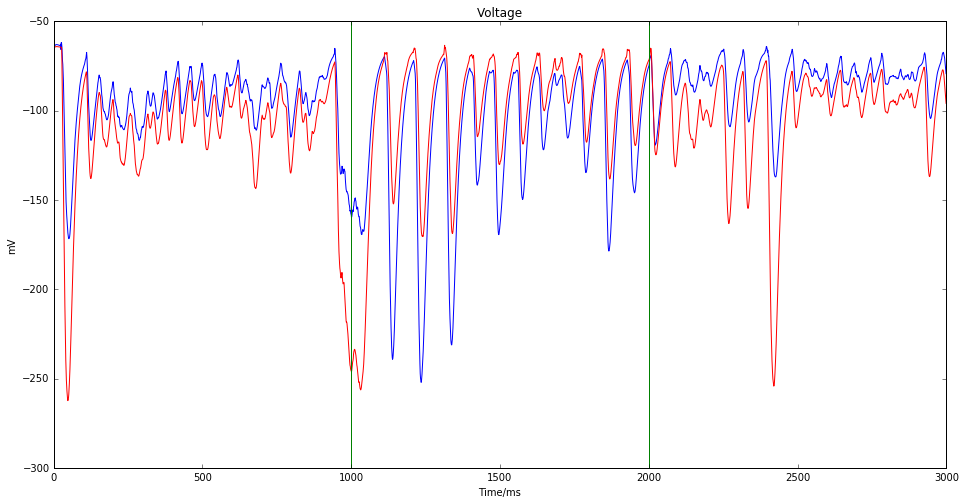

In [16]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.average(v_p1[:, 2].reshape(n_neurons, 3000), axis=0), c='b')
plt.plot(np.average(v_p2[:, 2].reshape(n_neurons, 3000), axis=0), c='r')
# for t in spikes_p1[:, 1]:
#     plt.axvline(t, ls='-', c='b', lw=1, alpha=.5)
# for t in spikes_p2[:, 1]:
#     plt.axvline(t, ls=':', c='r', lw=1, alpha=.7)
    
plt.axvline(run_time/ms, ls='-', c='g', lw=1, alpha=1)
plt.axvline(2*run_time/ms, ls='-', c='g', lw=1, alpha=1)
plt.xlabel('Time/ms')
plt.ylabel('mV')
plt.title('Voltage')

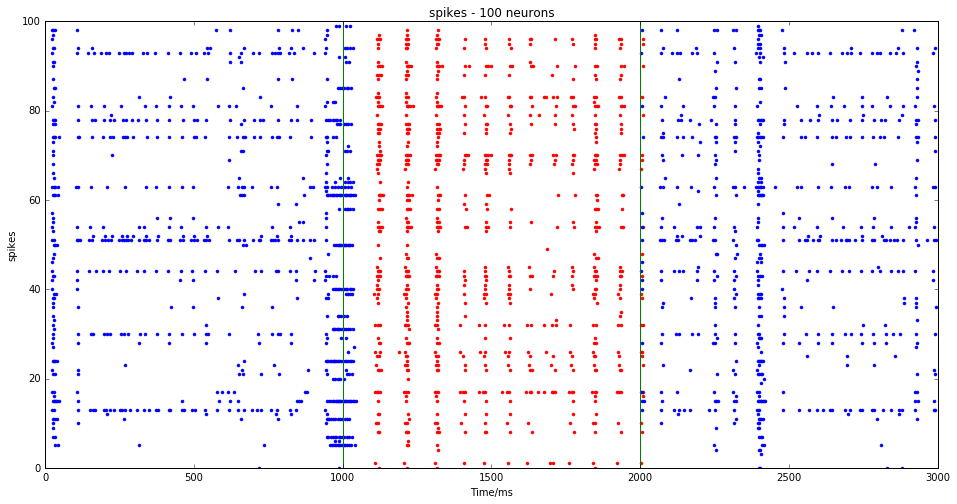

In [17]:
fig = plt.figure(figsize=(16,8))
plt.plot([i[1] for i in spikes_p2], [i[0] for i in spikes_p2], ".", c='r')
plt.plot([i[1] for i in spikes_p1], [i[0] for i in spikes_p1], ".", c='b')
plt.axvline(run_time/ms, ls='-', c='g', lw=1, alpha=1)
plt.axvline(2*run_time/ms, ls='-', c='g', lw=1, alpha=1)
plt.xlabel('Time/ms')
plt.ylabel('spikes')
plt.xlim([0, 3*run_time/ms])
plt.title('spikes - ' + str(n_neurons) + ' neurons')

In [18]:
np.count_nonzero(spikes_p2[:,1] > run_time/ms) / run_time / n_neurons

7.55 * hertz

In [19]:
np.count_nonzero(spikes_p1[:,1] < run_time/ms) / run_time / n_neurons

6.39 * hertz

In [20]:
np.count_nonzero(spikes_p1[:,1] > 2*run_time/ms) / run_time / n_neurons

5.75 * hertz

In [21]:
v_p1.shape

(300000, 3)